In [1]:
import os
import params
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.io import loadmat
from PIL import Image
import scipy


In [2]:
def get_ellipse(parameters,factor=1.5):
    amplitude, x0, y0, sigma_x, sigma_y, theta = parameters
    width = factor * 2.0 * sigma_x
    height = factor * 2.0 * sigma_y

    t = np.linspace(0, 2*np.pi, 360)
    
    Ell = np.array([sigma_x*np.cos(t) , sigma_y*np.sin(t)])
    
    R_rot = np.array([[np.cos(-np.deg2rad(theta)) , -np.sin(-np.deg2rad(theta))]
                      ,[np.sin(-np.deg2rad(theta)) , np.cos(-np.deg2rad(theta))]])  
    
    Ell = np.dot(R_rot, Ell)
    Ell[0,:] += x0
    Ell[1,:] += y0
    ell_size = np.abs(np.pi*width*height)
    ell_meas = 1-min(width, height)/max(width, height)
    
    return Ell, ell_size, ell_meas

def load_image_infos(file_name, key_name = "image_infos"):

    image_infos = scipy.io.loadmat(file_name)[key_name]

    XWorldLimits = image_infos[0][0][0][0]
    YWorldLimits = image_infos[0][0][1][0]
    ImageSize = image_infos[0][0][2][0]

    return XWorldLimits, YWorldLimits, ImageSize

# Cell1: Load triggers of the chosen recordings

In [3]:
exp = params.exp

rec_before="06_HoloStim1_SingleCell.raw" 

#put in this list all the recordings taken after the drug that you want to analyze ['rec1.raw', 'rec2.raw']
recs_after=[ "07_HoloStim2_18betaG_t20_SingleCell.raw"]

trig_data_before = load_obj(os.path.normpath(os.path.join(params.triggers_directory,'{}_{}_triggers.pkl'.format(exp,rec_before))))
stim_onsets_before = trig_data_before['indices']/params.fs 

nb_recs_after=len(recs_after)

trig_data_after = load_obj(os.path.normpath(os.path.join(params.triggers_directory,'{}_{}_triggers.pkl'.format(exp,recs_after[0]))))
stim_onsets_after = [trig_data_after['indices']/params.fs ]

if nb_recs_after==2:
    trig_data_after_2 = load_obj(os.path.normpath(os.path.join(params.triggers_directory,'{}_{}_triggers.pkl'.format(exp,recs_after[1]))))
    stim_onsets_after.append(trig_data_after['indices']/params.fs) 

# Cell 2: Load spikes of the chosen recordings

In [4]:
output_directory=params.output_directory
spike_trains=load_obj(os.path.join(output_directory, r'{}_fullexp_neurons_data.pkl'.format(exp)))

cells=list(spike_trains.keys())

spike_times_before=[]
for cell in cells:
    spike_times_before.append(spike_trains[cell][rec_before])
    
spike_times_after=[[],[]]
for cell in cells:
    spike_times_after[0].append(spike_trains[cell][recs_after[0]])
if nb_recs_after==2:
    for cell in cells:
        spike_times_after[1].append(spike_trains[cell][recs_after[1]])

# Cell3: Load from Matlab the positions on the 40x of the Amacrine cells (and so of the holograpyc spots) 

sometimes the Matlab program that controls the holograpic stimulation freezes and so it needs to be restarted. If this happens the spots that are presented before and after the drug might have a different order. Here the code that visualizes the spot positions in the two cases and authomatically matches them

Spot equivalence before and after the drug: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}


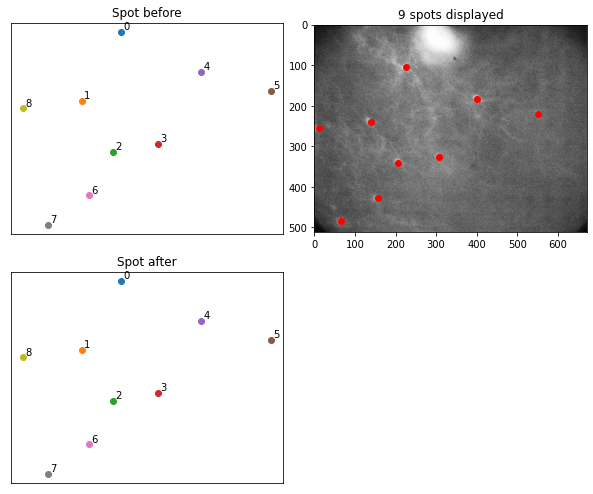

In [5]:
Freeze=False

DH_frames_filepath = r"/media/samuele/VIP.Project_18BG/VIP.Project/20220912_VIP.Project_18betaG.10uM/20220912_DHguiOptimization_VIP.Project_18BetaG/frames/DH_frames_20220912_18_28_12" ### change here
dh_frames = loadmat(DH_frames_filepath)
#an array with the coordinates of all the spots in the 40x reference
spots_coordinates_before = dh_frames["PatternImage"]
#an array that for each trigger has the number of the spot presented
order_spots_before=dh_frames["OrderFrames"][:,0]

fluorescence_image_path = r"/media/samuele/VIP.Project_18BG/VIP.Project/20220912_VIP.Project_18betaG.10uM/20220912_DHguiOptimization_VIP.Project_18BetaG/imgs/Retina_40x_Position2_(-60).jpg" ### change here

if Freeze==True:    

    DH_frames_filepath = r"" ### change here
    dh_frames = loadmat(DH_frames_filepath)
    spots_coordinates_after = dh_frames["PatternImage"]
    order_spots_after=dh_frames["OrderFrames"][:,0]

else: 
    spots_coordinates_after = spots_coordinates_before
    order_spots_after = order_spots_before
    
### Automatiezs spot_equivalence
spots_equivalence_1_2={}
for i, spot1_coord in enumerate(spots_coordinates_before):
    distances=np.zeros(spots_coordinates_after.shape[0])
    for j, spot2_coord in enumerate(spots_coordinates_after):
        dist=np.sqrt( ((spot1_coord-spot2_coord)**2).sum() )
        distances[j]=dist
#         print(spot1_coord, spot2_coord, dist)
    spots_equivalence_1_2[i]=distances.argmin()

print('Spot equivalence before and after the drug: {}'.format(spots_equivalence_1_2))

if nb_recs_after==2:
    if Freeze==True:
        DH_frames_filepath = r"" ### change here
        dh_frames = loadmat(DH_frames_filepath)
        spots_coordinates_after_2 = dh_frames["PatternImage"]
        order_spots_after_2=dh_frames["OrderFrames"][:,0]
        
    else: 
        spots_coordinates_after_2 = spots_coordinates_before
        order_spots_after_2 = order_spots_before
        
    spots_equivalence_1_3={}
    for i, spot1_coord in enumerate(spots_coordinates_before):
        distances=np.zeros(spots_coordinates_after_2.shape[0])
        for j, spot3_coord in enumerate(spots_coordinates_after_2):
            dist=np.sqrt( ((spot1_coord-spot3_coord)**2).sum() )
            distances[j]=dist
    #         print(spot1_coord, spot2_coord, dist)
        spots_equivalence_1_3[i]=distances.argmin()

    print('Second spot equivalence before and after the drug: {}'.format(spots_equivalence_1_3))

fig = plt.figure(figsize=(10,8))
gs = GridSpec(8, 12, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=1.6, hspace=1.5, figure=fig)
for i in range(4):
    if i==0:
        ax = fig.add_subplot(gs[0:4,0:6])
        for spot_nb in range(spots_coordinates_before.shape[0]):
            ax.scatter(spots_coordinates_before[spot_nb][0], spots_coordinates_before[spot_nb][1])
            x=spots_coordinates_before[spot_nb][0]
            y=spots_coordinates_before[spot_nb][1]
            ax.annotate(spot_nb, (x,y), (x+5,y+5))
            ax.set_title('Spot before')
            ax.set_xticks([])
            ax.set_yticks([])
    if i==1:
        ax = fig.add_subplot(gs[4:8,0:6])
        for spot_nb in range(spots_coordinates_after.shape[0]):
            plt.scatter(spots_coordinates_after[spot_nb][0], spots_coordinates_after[spot_nb][1])
            x=spots_coordinates_after[spot_nb][0]
            y=spots_coordinates_after[spot_nb][1]
            plt.annotate(spot_nb, (x, y), (x+5,y+5))
            ax.set_title('Spot after')
            ax.set_xticks([])
            ax.set_yticks([])
    if i==2:
        ax = fig.add_subplot(gs[0:4,6:12])
        im = Image.open(fluorescence_image_path)
        ax.imshow(np.array(im)[:,:,0][::-1,:], cmap='gray')
        for spot in spots_coordinates_before:
            ax.scatter(spot[0], np.array(im)[:,:,0].shape[0]-spot[1], color='r')
        ax.set_title("{} spots displayed".format(spots_coordinates_before.shape[0]))
        
    if i==3:
        if nb_recs_after==2:
            ax = fig.add_subplot(gs[4:8,6:121])
            for spot_nb in range(spots_coordinates_after_2.shape[0]):
                ax.scatter(spots_coordinates_after_2[spot_nb][0], spots_coordinates_after_2[spot_nb][1])
                x=spots_coordinates_after_2[spot_nb][0]
                y=spots_coordinates_after_2[spot_nb][1]
                plt.annotate(spot_nb, (x, y), (x+5,y+5))
            ax.set_title('Second spot after')
            ax.set_xticks([])
            ax.set_yticks([])
        else:continue


# Cell 4: Calculate rasters and PSTHS before and after the drug

It requires Cell 1, Cell 2 and Cell 3 to be run

In [6]:
analyse = {}

nb_triggers_by_repetition = 1
spot_duration= 0.5
duration_repetition = 1
bin_size = 0.050
time_before_stim=0.25   # in seconds

nb_spots=spots_coordinates_before.shape[0]
nb_repetitions =int(stim_onsets_before.shape[0]/nb_spots) #20

if nb_recs_after==1:recordings=['before', 'after']
if nb_recs_after==2:recordings=['before', 'after', 'after_2']
    
for recording in recordings:
    if recording=='before':
        triggers=stim_onsets_before
        spots_order=order_spots_before
        spikes=spike_times_before
    if recording=='after':
        triggers=stim_onsets_after[0]
        spots_order=order_spots_after
        spikes=spike_times_after[0]
        spot_equivalence=spots_equivalence_1_2
    if recording=='after_2':
        triggers=stim_onsets_after[1]
        spots_order=order_spots_after_2
        spikes=spike_times_after[1]
        spot_equivalence=spots_equivalence_1_3
    
    for spot_nb in range(1,nb_spots+1):   #the numbering is MAtlab's  
        
        if recording=='before': equiv_spot = spot_nb
        else: equiv_spot = spot_equivalence[spot_nb-1]+1
        
        # Find the trigger indices that correspond to the presentation of this holography spot
        sequence_first_indices = np.where(spots_order==equiv_spot)[0]

        # Find the corresponding trigger times (first and last)
        repeated_sequences_times = []
        for i in sequence_first_indices:
            times = triggers[i:i+nb_triggers_by_repetition+1]
            repeated_sequences_times.append([times[0], times[-1]])

        for cell_idx,cell_nb in tqdm(enumerate(cells)):
            if not cell_nb in analyse.keys(): analyse[cell_nb] = {}
            if not recording in analyse[cell_nb].keys(): analyse[cell_nb][recording] = {}

            SU_sptimes = spikes[cell_idx]

            #for each cell and each spot here the spike trains of the 20 spot repetitions are isolated
            spike_trains = []
            for i in range(len(repeated_sequences_times)):
                spike_train = SU_sptimes[(SU_sptimes >= repeated_sequences_times[i][0]-time_before_stim) & (SU_sptimes <= repeated_sequences_times[i][0]+spot_duration+time_before_stim)]
                spike_trains += [spike_train-repeated_sequences_times[i][0]]

    #         # Align the spike trains
    #         for i in range(len(spike_trains)):
    #             spike_trains[i] = spike_trains[i] - repeated_sequences_times[i][0]


            # Compute psth 
            nb_bins = int(duration_repetition/bin_size)
            binned_spikes = np.empty((nb_repetitions,nb_bins))
            for i in range(nb_repetitions):
                binned_spikes[i,:] = np.histogram(spike_trains[i], bins=nb_bins, range=(-time_before_stim,spot_duration+time_before_stim))[0] 

            # Compute average
#             binned_spikes = np.mean(binned_spikes, axis=0) 

            # Transform spike count in firing rate
            binned_spikes = binned_spikes / bin_size

            analyse[cell_nb][recording][spot_nb-1]={"spike_trains": spike_trains, "binned_sp_trains": binned_spikes}

# save the results
np.save(os.path.join(output_directory,'Holo_flash_data'), analyse)    #CHANGE THE NAME HERE FOR THE SAVE!!

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# Cell 5: Plotting. RGC specific activation

It requires Cell 4 to be run

In [20]:
registration_directory=params.registration_directory
XWorldLimits, YWorldLimits, ImageSize = load_image_infos(os.path.join(registration_directory,"sta_infos.mat"), key_name="sta_infos")

#these are the coordinates of the holographic spots in the MEA frame of reference. Their frame of reference
#does not start from 0
dh_points_mea = loadmat(os.path.join(registration_directory,"dh_points_mea.mat"))['dh_points_mea']
nb_spots=dh_points_mea.shape[0]

#offset them so that they do start from zero like the reference frame in which the ellipse was fitted
offsetted_spots_coords = np.zeros(dh_points_mea.shape)
for i_spot in range(nb_spots):
    spot_coord = dh_points_mea[i_spot]
    offsetted_spots_coords[i_spot] = spot_coord-np.array([XWorldLimits[0], YWorldLimits[0]])
    
fig_directory = os.path.normpath(os.path.join(output_directory,r'Holo_flash_figs/RGC_specific_response'))
if not os.path.isdir(fig_directory): os.makedirs(fig_directory)
    
sta_results=np.load(os.path.join(output_directory,'sta_data_3D_fitted.pkl'),allow_pickle=True)
Chirp_data = np.load(os.path.join(output_directory, '{}_cell_typing_data.pkl'.format(exp)), allow_pickle=True)
registered_ellipses = np.load(os.path.join(output_directory, 'Well_fitted_registered_ellipses.npy'), allow_pickle=True).item()
Distances= np.load(os.path.join(output_directory,'{}_RF_Holo_spots_distances.npy'.format(exp)), allow_pickle=True).item()
cells=list(Chirp_data.keys())

#generate customized colormap
cmap = plt.cm.get_cmap('gist_ncar')  #turbo
colors=np.linspace(0,0.9, nb_spots)
col_list=[]
for color in colors:
    rgba = cmap(color)
    col_list.append(rgba)

labels=['control', '18BG+20']
colors=['blue', 'orange']
    
for cell_nb in tqdm(cells[:]):
        
    if Chirp_data[cell_nb]['type']=='Not assigned': cluster=''
    else: cluster = Chirp_data[cell_nb]['type']
    
    #find cell's max firing rate for plotting purposes
    max_fr=0
    for rec in recordings:
        for spot_nb in range(nb_spots):
            if np.mean(analyse[cell_nb][rec][spot_nb]['binned_sp_trains'], axis=0).max()>max_fr:
                max_fr=np.mean(analyse[cell_nb][rec][spot_nb]['binned_sp_trains'], axis=0).max()
    
    fig = plt.figure(figsize=(3*(nb_recs_after+2),2*nb_spots+2))
    gs = GridSpec(3*nb_spots+6, 5*(nb_recs_after+2)+3+6, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.4, hspace=1.5, figure=fig)
    
    #plot spatial STA
    ax = fig.add_subplot(gs[0:4, 0:4])
    ax.set_title("STA",fontsize=12 )
    spatial = sta_results[cell_nb]['center_analyse']['Spatial']
    spatial = spatial**2*np.sign(spatial)
    cmap='RdBu_r'
    image = ax.imshow(spatial, cmap=cmap,interpolation='gaussian')
    abs_max = 0.5*max(np.max(spatial), abs(np.min(spatial)))
    image.set_clim(-abs_max,abs_max)
    ax.set_xticks([])
    ax.set_yticks([])
    
    #plot the 40x fluorescence image with the spots positions
    ax = fig.add_subplot(gs[3:6,0:6])
    im = Image.open(fluorescence_image_path)
    ax.imshow(np.array(im)[:,:,0][::-1,:], cmap='gray')
    for spot_nb, spot in enumerate(spots_coordinates_before):
        ax.scatter(spot[0], np.array(im)[:,:,0].shape[0]-spot[1], s=5, color=col_list[spot_nb])
        ax.annotate(spot_nb, (spot[0],np.array(im)[:,:,0].shape[0]-spot[1]), (spot[0],np.array(im)[:,:,0].shape[0]-spot[1]))
#     ax.set_title("{} spots displayed".format(spots_coordinates_before.shape[0]))
    ax.set_xticks([])
    ax.set_yticks([])
    
    distance=False
    if cell_nb in Distances.keys(): distance=True
    
    if distance:
        
        #find cell's bigger relative distance for plotting purposes
        max_rel_dist=0
        for spot_nb in range(nb_spots):
            if Distances[cell_nb][spot_nb]['relative_distance']>max_rel_dist: max_rel_dist=Distances[cell_nb][spot_nb]['relative_distance']
    
        
        #plot the ellipse and the holographic spots with their absolute distance
        ax = fig.add_subplot(gs[0:6,6:15])
        for spot_nb in range(nb_spots):
            spot_coord = offsetted_spots_coords[spot_nb]
            ax.scatter(spot_coord[0], spot_coord[1], s=25, color=col_list[spot_nb])
            ax.annotate(int(np.round(Distances[cell_nb][spot_nb]['absolute_distance'],0)), (spot_coord[0],spot_coord[1]), (spot_coord[0]+15,spot_coord[1]+15), fontsize=8)
        
        ell_params=registered_ellipses[cell_nb]
        x,y=ell_params[1:3]
        ellipse,_,_=get_ellipse(ell_params, factor=2)
        ax.scatter(x,y, color='black', s=10)
        ax.scatter(ellipse[0], ellipse[1], s=0.5)

        ax.set_xlim([x-400, x+400])
        ax.set_ylim([y-400, y+400])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.invert_yaxis()
        ax.set_title('Absolute Distances (um)', fontsize=12)
    
        #initialize the relative distance scatter plot
        ax_scatter = fig.add_subplot(gs[0:5,17:])
        ax_scatter.set_title('Relative distance vs Activation', fontsize=12)
        ax_scatter.axvline(1, ls='--', color='grey')
        ax_scatter.axhline(0, ls='-', color='k')
        ax_scatter.set_xlim([0, max_rel_dist+0.5])
        ax_scatter.set_xlabel('Relative distance', fontsize=12)
        ax_scatter.set_ylabel('Cell activation',labelpad=0.001 , fontsize=12)
    
        #reorder the spots by their distance from the RF
        spots_abs_dists=[]
        for spot_nb in range(nb_spots):
            spots_abs_dists.append(Distances[cell_nb][spot_nb]['absolute_distance'])
        reord_spots=np.array(spots_abs_dists).argsort()
        
    if distance: spots_order = reord_spots
    else: spots_order = range(nb_spots)
    
    for spot_idx, spot_nb in enumerate(spots_order):
        for idx, flag in enumerate(list([0]+recordings)):
            
            ax = fig.add_subplot(gs[6+spot_idx*3:6+(spot_idx+1)*3, idx*5+3:(idx+1)*5+3])
            #plotting PSTHS
            if flag==0:
                for rec_id, rec in enumerate(recordings):
                    binned_reps=analyse[cell_nb][rec][spot_nb]['binned_sp_trains']
                    psth = np.mean(binned_reps, axis=0) 
                    ax.plot(psth, label=labels[rec_id], color=colors[rec_id])
                    
                    if max_fr!=0: ax.set_ylim([0,max_fr])
                    ax.set_yticks([])
                    ax.set_xticks([time_before_stim/bin_size, (time_before_stim+spot_duration)/bin_size], [0, spot_duration])
                    if spot_idx==0:ax.legend()
                    for j in [time_before_stim/bin_size, (time_before_stim+spot_duration)/bin_size]:
                        ax.axvline(j, ls='--',color='grey')
                    if spot_idx==nb_spots-1: ax.set_xlabel('Time (s)')
                    
                    
                    baseline_activity = binned_reps[:, :int(time_before_stim/bin_size)]
                    baseline_activity_per_rep = np.mean(baseline_activity, axis=1)
                    mean_off_time = np.mean(baseline_activity_per_rep)
                    std_off_time = np.std(baseline_activity_per_rep)/np.sqrt(baseline_activity_per_rep.size)
                    
                    activity_during_spot = binned_reps[:, int(time_before_stim/bin_size):int((time_before_stim+spot_duration)/bin_size)]
                    activity_during_spot_per_rep = np.mean(activity_during_spot, axis=1)
                    mean_on_time = np.mean(activity_during_spot_per_rep)
                    std_on_time = np.std(activity_during_spot_per_rep) /np.sqrt(activity_during_spot_per_rep.size)
                
                    peak_on_time = psth[int(time_before_stim/bin_size):int((time_before_stim+spot_duration)/bin_size)].max()
                    std_on_psth_across_time=np.std(psth[int(time_before_stim/bin_size):int((time_before_stim+spot_duration)/bin_size)])
                    
                    is_cell_transient = peak_on_time-mean_on_time-2.5*std_on_psth_across_time
                    
                    if rec_id==0 and is_cell_transient > 0: # if the cell is detected as transient
                        if mean_off_time==0 or mean_off_time-3*std_off_time<0: 
                            if mean_on_time==0 or mean_on_time-3*std_on_time<0:
                                activation=0
                                activation_err=std_on_time
                            else:
                                activation=peak_on_time
                                activation_err=0
                        else:
                            activation=(peak_on_time-mean_off_time)/mean_off_time
                            activation_err = std_off_time
                    if rec_id==0 and is_cell_transient < 0: # if the cell is detected as sustained
                        if mean_off_time==0 or mean_off_time-3*std_off_time<0:
                            if mean_on_time==0 or mean_on_time-3*std_on_time<0:
                                activation = 0
                                activation_err = std_on_time 
                            else:
                                activation = mean_on_time
                                activation_err = std_on_time
                        else:
                            activation=(mean_on_time-mean_off_time)/mean_off_time
                            activation_err = np.abs(mean_on_time/mean_off_time)*np.sqrt( (std_on_time/mean_on_time)**2 + (std_off_time/mean_off_time)**2 )
                    if rec_id==0 and is_cell_transient == 0.:
                        activation = 0
                        activation_err = 0
                        
#                     print('Spot{}: activation {}, type {} '.format(spot_nb,activation,is_cell_transient))
#                     print(mean_off_time, mean_on_time, peak_on_time)
#                     print(activation_err, std_on_time, std_off_time)
                    if rec_id==0: 
                        if distance:
                            #scatter a point in the relative distance scatter pplot
                            ax_scatter.scatter(Distances[cell_nb][spot_nb]['relative_distance'], activation, color=col_list[spot_nb])
                            ax_scatter.annotate(spot_nb, (Distances[cell_nb][spot_nb]['relative_distance'],activation), (Distances[cell_nb][spot_nb]['relative_distance']+0.1,activation+0.1), fontsize=8)
                            ax_scatter.errorbar(Distances[cell_nb][spot_nb]['relative_distance'],activation,yerr=activation_err,color=col_list[spot_nb],  linestyle="-", lw=0.5)
                    
                        #plot a bar plot with the PSTHs averages per each spot
                        ax_bar = fig.add_subplot(gs[6+spot_idx*3:6+(spot_idx+1)*3, 0:3])
                        errors=[std_off_time, std_on_time, 0]
                        ax_bar.bar([0.2, 0.4, 0.6], [mean_off_time, mean_on_time, peak_on_time],yerr=errors, width=0.1, color=['blue','red','crimson'])
                        if max_fr!=0: ax_bar.set_ylim([0, max_fr])
                        ax_bar.set_xticks([])
                        ax_bar.set_ylabel('Spot {}'.format(spot_nb), fontsize=20)
                        if spot_idx==1: ax_bar.set_title('Modulation in Hz', fontsize=8)
                        if spot_idx==nb_spots-1:
                            ax_bar.set_xticks([0.2, 0.4, 0.6], ['mean_OFF', 'mean_ON', 'peak_ON'], rotation=45)
            else:
                #plotting Rasters
                ax.eventplot(analyse[cell_nb][flag][spot_nb]['spike_trains'], color=colors[idx-1])
                ax.set_ylim([0,nb_repetitions])
                ax.set_xlim([-time_before_stim,spot_duration+time_before_stim])
                ax.set_yticks([])
                if spot_idx==0: ax.set_title('{}'.format(labels[idx-1]))
                ax.set_xticks([0, spot_duration], [0, spot_duration])
                for j in [0, spot_duration]:
                    ax.axvline(j, ls='--',color='grey')
                if spot_idx==nb_spots-1: ax.set_xlabel('Time (s)')
        

    fig.suptitle('Ganglion cell {}, all spots \n Cell_group {}'.format(cell_nb, cluster), fontsize=35)
    fig_file = os.path.join(fig_directory,f'Group_{cluster}_Cell_{cell_nb}.png')
    plt.savefig(fig_file, dpi=fig.dpi)
    plt.close()

  0%|          | 0/163 [00:00<?, ?it/s]

In [17]:
np.where(np.array(cells)==157)

(array([29]),)

# Cell6: Plotting. Amacrine specific activation

This plot is generated including only the cells that had a good transformed ellipse fitting and so they have a measure of distance from the Amacrine cell

Requires cell 4 to be run

In [21]:
Chirp_data = np.load(os.path.join(output_directory, '{}_cell_typing_data.pkl'.format(exp)), allow_pickle=True)
registered_ellipses = np.load(os.path.join(output_directory, 'Well_fitted_registered_ellipses.npy'), allow_pickle=True).item()
Distances= np.load(os.path.join(output_directory,'{}_RF_Holo_spots_distances.npy'.format(exp)), allow_pickle=True).item()

cells= list(Distances.keys())

cell_clusters={}
cell_clusters['Not assigned']=[]
for cell_nb in cells:
    cell_type=Chirp_data[cell_nb]['type']
    if cell_type not in cell_clusters.keys(): cell_clusters[cell_type]=[]
    cell_clusters[cell_type].append(cell_nb)
    
nb_clusters=len(list(cell_clusters.keys()))-1
nb_non_assigned_cells=len(cell_clusters['Not assigned'])
nb_cells_in_bigger_cluster=0
for i in range(nb_clusters):
    print('Cluster {}: {} cells \t {}'.format(i, len(cell_clusters[i]), cell_clusters[i]) )
    if len(cell_clusters[i])>nb_cells_in_bigger_cluster: nb_cells_in_bigger_cluster=len(cell_clusters[i])
    
print(nb_clusters, nb_cells_in_bigger_cluster, nb_non_assigned_cells)

Cluster 0: 11 cells 	 [211, 282, 320, 326, 380, 405, 416, 471, 478, 490, 500]
Cluster 1: 4 cells 	 [185, 242, 382, 522]
Cluster 2: 3 cells 	 [157, 220, 516]
Cluster 3: 8 cells 	 [30, 235, 443, 470, 473, 483, 491, 540]
Cluster 4: 4 cells 	 [111, 459, 481, 518]
Cluster 5: 12 cells 	 [238, 315, 422, 438, 449, 450, 465, 479, 521, 531, 535, 538]
Cluster 6: 5 cells 	 [40, 519, 529, 536, 541]
Cluster 7: 1 cells 	 [127]
Cluster 8: 1 cells 	 [455]
Cluster 9: 1 cells 	 [291]
Cluster 10: 1 cells 	 [476]
Cluster 11: 4 cells 	 [174, 312, 462, 472]
Cluster 12: 1 cells 	 [133]
Cluster 13: 1 cells 	 [457]
Cluster 14: 1 cells 	 [545]
15 12 41


In [79]:
fig_directory = os.path.normpath(os.path.join(output_directory,r'Holo_flash_figs/Spot_specific_response'))
if not os.path.isdir(fig_directory): os.makedirs(fig_directory)

DH_frames_filepath = r"/media/samuele/VIP.Project_18BG/VIP.Project/20220912_VIP.Project_18betaG.10uM/20220912_DHguiOptimization_VIP.Project_18BetaG/frames/DH_frames_20220912_18_28_12" ### change here
dh_frames = loadmat(DH_frames_filepath)
#an array with the coordinates of all the spots in the 40x reference
spots_coordinates_before = dh_frames["PatternImage"]
fluorescence_image_path = r"/media/samuele/VIP.Project_18BG/VIP.Project/20220912_VIP.Project_18betaG.10uM/20220912_DHguiOptimization_VIP.Project_18BetaG/imgs/Retina_40x_Position2_(-60).jpg" ### change here

XWorldLimits, YWorldLimits, ImageSize = load_image_infos(os.path.join(registration_directory,"sta_infos.mat"), key_name="sta_infos")

#these are the coordinates of the holographic spots in the MEA frame of reference. Their frame of reference
#does not start from 0
dh_points_mea = loadmat(os.path.join(registration_directory,"dh_points_mea.mat"))['dh_points_mea']
nb_spots=dh_points_mea.shape[0]

#offset them so that they do start from zero like the reference frame in which the ellipse was fitted
offsetted_spots_coords = np.zeros(dh_points_mea.shape)
for i_spot in range(nb_spots):
    spot_coord = dh_points_mea[i_spot]
    offsetted_spots_coords[i_spot] = spot_coord-np.array([XWorldLimits[0], YWorldLimits[0]])

labels=['control', '18BG+20']
colors=['blue', 'orange']
    
nb_columns=nb_clusters+int(nb_non_assigned_cells/nb_cells_in_bigger_cluster)+1
for spot_nb in tqdm(range(nb_spots)[:]):

    fig = plt.figure(figsize=(3*nb_columns,2*nb_cells_in_bigger_cluster+3))
    gs = GridSpec(3*nb_cells_in_bigger_cluster+5, 5*(nb_columns), left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=2.5, hspace=1.5, figure=fig)  
    
    for clus_idx in range(nb_columns):
        if clus_idx<nb_clusters:
            #initilize the mosaic
            mosaic= fig.add_subplot(gs[0:5, clus_idx*5: clus_idx*5+5])
            spot_coord = offsetted_spots_coords[spot_nb]
            mosaic.scatter(spot_coord[0], spot_coord[1], s=25, color='red')
            mosaic.annotate(spot_nb, (spot_coord[0],spot_coord[1]), (spot_coord[0]+2,spot_coord[1]+2), fontsize=8)
            mosaic.set_title('Group {}'.format(clus_idx))
            mosaic.set_xticks([])
            mosaic.set_yticks([])
            mosaic.invert_yaxis()
            
            #find spot's max firing rate for this cell type for plotting purposes
            max_fr=0
            for rec in recordings:
                for cell in cell_clusters[clus_idx]:
                    if np.mean(analyse[cell][rec][spot_nb]['binned_sp_trains'], axis=0).max()>max_fr:
                        max_fr=np.mean(analyse[cell][rec][spot_nb]['binned_sp_trains'], axis=0).max()
            
            #reorder the GCs by their distance from the holo spot
            rgcs_abs_dists=[]
            for cell in cell_clusters[clus_idx]:
                rgcs_abs_dists.append(Distances[cell][spot_nb]['absolute_distance'])
            reordered_rgcs=np.array(cell_clusters[clus_idx])[np.array(rgcs_abs_dists).argsort()]
            
            for row, cell in enumerate(reordered_rgcs):
                
                #plot the holo spot psth of all the cells in the given cluster, ordered by absolute distance
                ax = fig.add_subplot(gs[3*row+5:5+(row+1)*3, clus_idx*5: (clus_idx+1)*5])
        
                for rec_id, rec in enumerate(recordings):
                    binned_reps=analyse[cell][rec][spot_nb]['binned_sp_trains']
                    psth = np.mean(binned_reps, axis=0) 
                    ax.plot(psth, label=labels[rec_id], color=colors[rec_id])
                    ax.set_title('Cell {}'.format(cell))
                    ax.set_ylabel("{}".format(row))
                    if max_fr!=0: ax.set_ylim([0,max_fr])   #scale the plots according to the most firing cell of this type
                    ax.set_xticks([time_before_stim/bin_size, (time_before_stim+spot_duration)/bin_size], [0, spot_duration])
                    if row==0:ax.legend()
                    for j in [time_before_stim/bin_size, (time_before_stim+spot_duration)/bin_size]:
                        ax.axvline(j, ls='--',color='grey')
                    if row==len(cell_clusters[clus_idx])-1: ax.set_xlabel('Time (s)')
                
                #plot an ellipse in the cell type mosaic
                ell_params=registered_ellipses[cell]
                x,y=ell_params[1:3]
                mosaic.scatter(x, y, color='black', s=0.3) #color=col_list[spot_nb]
                mosaic.annotate(row, (x,y), (x+0.1,y+0.1), fontsize=8)
                ellipse,_,_=get_ellipse(ell_params, factor=2)
                mosaic.scatter(ellipse[0], ellipse[1], s=0.1)
        else:
            #plot the psths of the cells that were not clustered
            for row, cell in enumerate(cell_clusters['Not assigned']):
                
                new_row = row%nb_cells_in_bigger_cluster
                new_column = int(row/nb_cells_in_bigger_cluster)
                
                #plot the holo spot psth of all the cells 
                ax = fig.add_subplot(gs[3*new_row+5:5+(new_row+1)*3, nb_clusters*5+new_column*5: nb_clusters*5+(new_column+1)*5])
                if row==0: ax.set_title('Non clustered')
                for rec_id, rec in enumerate(recordings):
                    binned_reps=analyse[cell][rec][spot_nb]['binned_sp_trains']
                    psth = np.mean(binned_reps, axis=0) 
                    ax.plot(psth, label=labels[rec_id], color=colors[rec_id])
                    ax.set_title('Cell {}'.format(cell))
                    ax.set_ylabel("{}".format(row))
#                     if max_fr!=0: ax.set_ylim([0,max_fr])   #scale the plots according to the most firing cell of this type
                    ax.set_xticks([time_before_stim/bin_size, (time_before_stim+spot_duration)/bin_size], [0, spot_duration])
                    if row==0:ax.legend()
                    for j in [time_before_stim/bin_size, (time_before_stim+spot_duration)/bin_size]:
                        ax.axvline(j, ls='--',color='grey')
                    if row==nb_cells_in_bigger_cluster-1: ax.set_xlabel('Time (s)')
    
    
    fig.suptitle('Spot {}, all gangliion cells'.format(spot_nb), fontsize=35)
    fig_file = os.path.join(fig_directory,f'Spot_{spot_nb}.png')
    plt.savefig(fig_file, dpi=fig.dpi)
    plt.close()

  0%|          | 0/9 [00:00<?, ?it/s]